In [1]:
import pymc
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
from sklearn.preprocessing import StandardScaler


from pymc import HalfCauchy, Model, Normal, sample

In [27]:
n = 200
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, n)
true_regression_line = true_intercept + true_slope * x
y = true_regression_line + np.random.normal(scale=0.5, size=n)

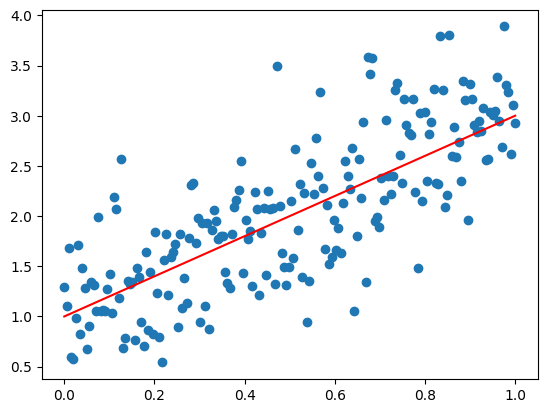

In [31]:
plt.scatter(x, y)
plt.plot(x, true_regression_line, color="red")

In [33]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


c:\Users\matej\miniconda3\envs\MLDS_HW1\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 66 seconds.


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

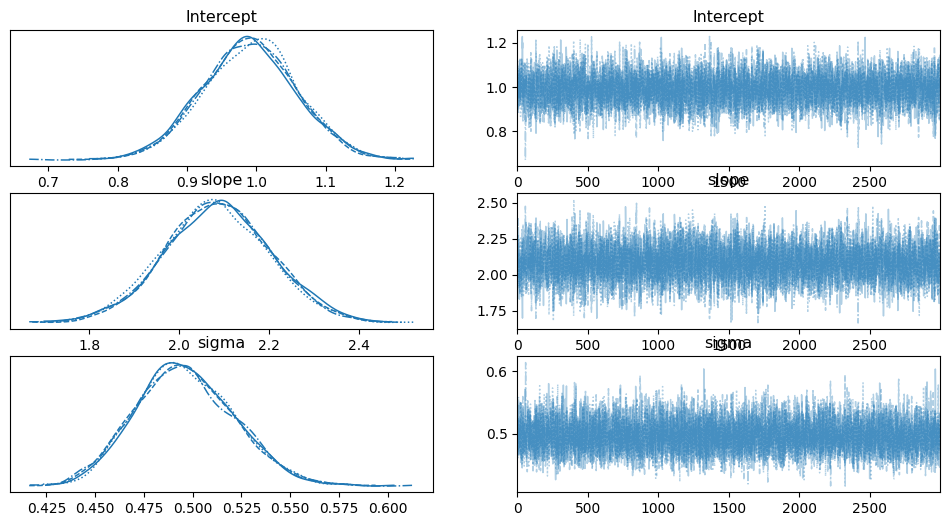

In [38]:
az.plot_trace(idata)

In [44]:
az.ess(idata)["slope"].values

array(4978.10266109)

In [2]:
df = pd.read_csv("football.csv", delimiter=";")

In [55]:
test = df.loc[df["GoalsScored"].isna()]
train = df.loc[df["GoalsScored"].notna()]

X_train = train.drop(columns="GoalsScored").to_numpy()
y_train = train["GoalsScored"].to_numpy()

X_test = test.drop(columns="GoalsScored").to_numpy()
y_test = test["GoalsScored"].to_numpy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [4]:
with pm.Model() as poisson_model:

    b_0 = Normal("b_0", 0, sigma=5)
    b = Normal("b", 0, sigma=5, shape=X_train.shape[1])
    lambda_ = pm.math.exp(b_0 + pm.math.dot(X_train, b))

    y_obs = pm.Poisson("y_obs", mu=lambda_, observed=y_train)

    idata = sample(3000)

Initializing NUTS using jitter+adapt_diag...
c:\Users\matej\miniconda3\envs\MLDS_HW1\Lib\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_0, b]


c:\Users\matej\miniconda3\envs\MLDS_HW1\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 75 seconds.


array([[<Axes: title={'center': 'b_0'}>, <Axes: title={'center': 'b_0'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

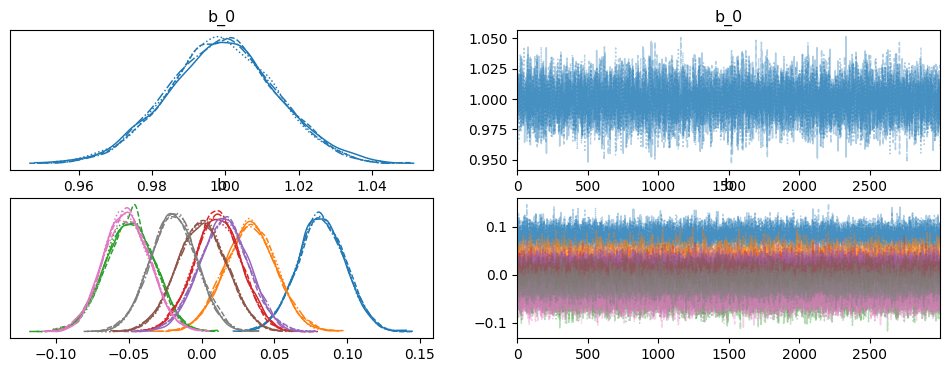

In [5]:
az.plot_trace(idata)

array([[<Axes: title={'center': 'b_0'}>,
        <Axes: title={'center': 'b\n0'}>,
        <Axes: title={'center': 'b\n1'}>],
       [<Axes: title={'center': 'b\n2'}>,
        <Axes: title={'center': 'b\n3'}>,
        <Axes: title={'center': 'b\n4'}>],
       [<Axes: title={'center': 'b\n5'}>,
        <Axes: title={'center': 'b\n6'}>,
        <Axes: title={'center': 'b\n7'}>]], dtype=object)

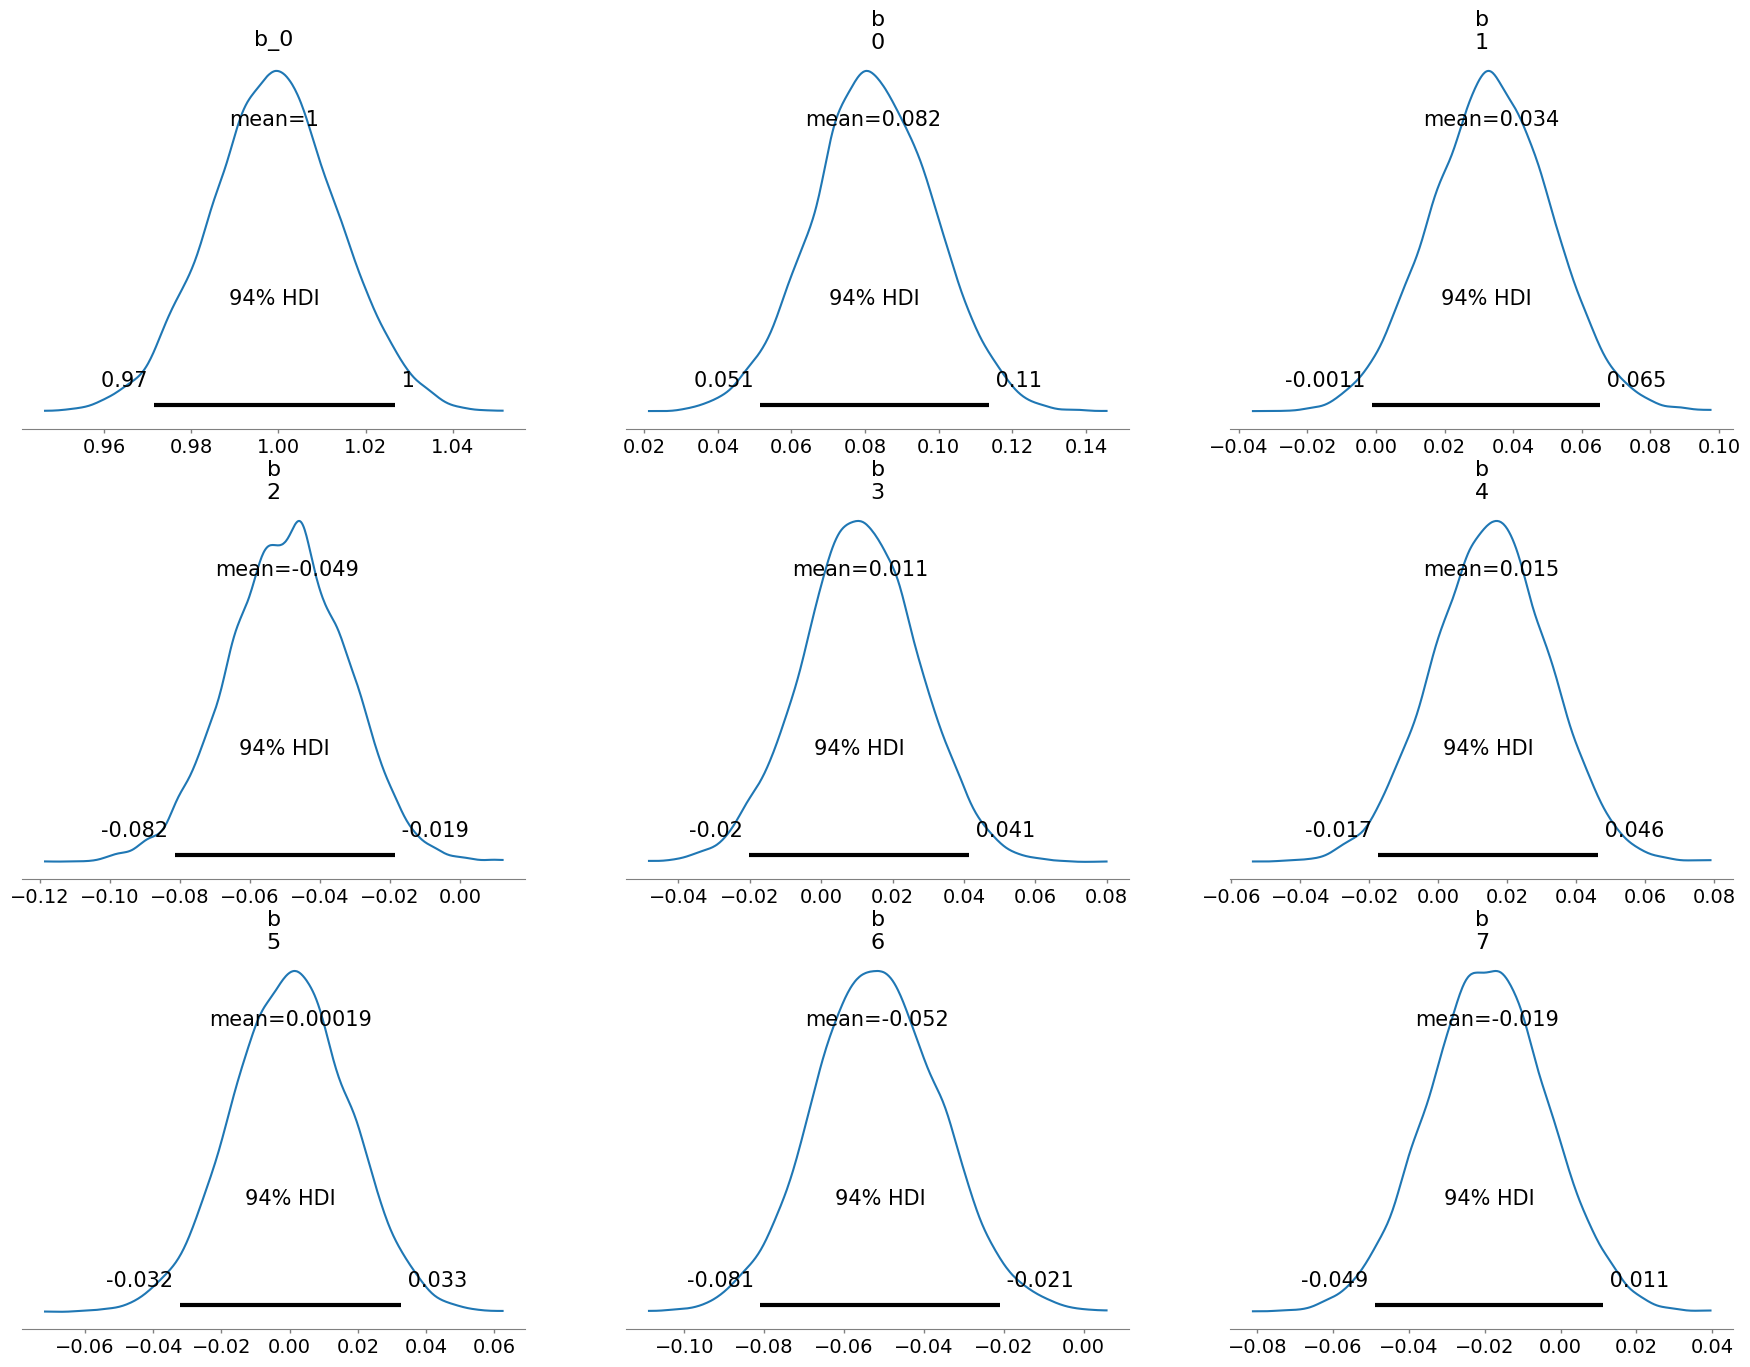

In [7]:
az.plot_posterior(idata)

# Laplace Approximation

In [8]:
from scipy.optimize import minimize

X_train_1 = np.column_stack((X_train, np.ones(X_train.shape[0])))
X_test
betas_0 = np.zeros(X_train_1.shape[1])
alpha = 5

def neg_log_posterior(betas, X, y, alpha):
    eta = X @ betas
    return np.sum(np.exp(eta) - y * eta) + (1 / (2 * alpha)) * np.sum(betas**2)

# def grad(betas, X, y, alpha):
#     return - X @ y + X @ np.exp(X @ betas) + 1/alpha * betas

def grad(betas, X, y, alpha):
    return X.T @ (np.exp(X @ betas) - y) + (1 / alpha) * betas

# def hessian(betas, X, y, alpha):
#     return - X @ np.diag(np.exp(X @ betas)) @ X + 1/alpha * np.eye(X.shape[0], X.shape[0])

def hessian(betas, X, y, alpha):
    mu = np.exp(X @ betas)
    D = np.diag(mu)
    return X.T @ D @ X + (1 / alpha) * np.eye(X.shape[1])

res = minimize(
    neg_log_posterior,
    betas_0,
    args=(X_train_1, y_train, alpha),
    method='Newton-CG',  # or 'Newton-CG', 'BFGS', etc.
    jac=grad,
    hess=hessian
)

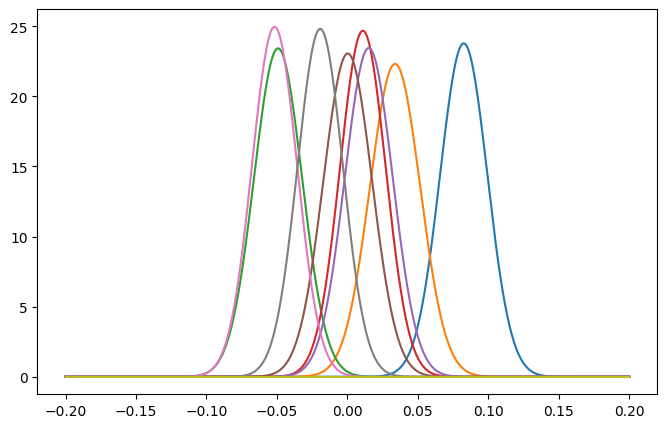

In [74]:
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal, mode
import numpy as np
betas = res.x

hess = hessian(betas, X_train_1, y_train, alpha)
cov = np.linalg.inv(hess)

x_vals = np.linspace(-0.2, 0.2, 500)  # Adjust range if needed
plt.figure(figsize=(8, 5))

for i, b in enumerate(betas):
    mean = b
    variance = cov[i][i]
    std = np.sqrt(variance)
    y_vals = norm.pdf(x_vals, loc=mean, scale=std)
    plt.plot(x_vals, y_vals, label=f'β{i}')


# Making point predictions

Loss functions

In [111]:
def squared_error(y_pred, y_true):
    return(np.mean((y_pred - y_true)**2))

def absolute_error(y_pred, y_true):
    return(np.mean(np.abs(y_pred - y_true)))

def accuracy(y_pred, y_true):
    correct_counts = 0

    for s in range(y_pred.shape[0]):  # iterate over samples
        sample_pred = np.round(y_pred[s, :])       # shape (N,)
        correct = np.sum(sample_pred == np.round(y_true))
        correct_counts += correct

    accuracy = correct_counts / (y_pred.shape[0] * y_pred.shape[1])
    return accuracy

In [115]:
rv = multivariate_normal(betas, cov)

np.random.seed(42)

beta_matrix = rv.rvs(1000)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = np.column_stack((X_test_scaled, np.ones(X_test_scaled.shape[0])))

predictions = np.exp(beta_matrix @ X_test_scaled.T)

y_samples = np.random.poisson(lam=predictions)

ground_truths_for_MSE = y_samples.mean(axis=0)

ground_truths_for_MAE = np.median(y_samples, axis=0)

ground_truths_for_ACC = mode(np.round(y_samples), axis=0)

In [117]:
display(squared_error(y_samples, ground_truths_for_MSE))
display(absolute_error(y_samples, ground_truths_for_MAE))
accuracy(y_samples, ground_truths_for_ACC)

np.float64(2.77835922)

np.float64(1.30244)

np.float64(0.24431)